Анализ электрокардиограммы (ЭКГ) - одна из задач, с помощью которой глубокое обучение может помочь врачам быстрее и точнее диагностировать патенты. Набор данных содержит только 100 образцов для обучения и 100 образцов для тестирования. Каждая серия отслеживает электрическую активность, зарегистрированную во время одного удара сердца. Два класса - это нормальное сердцебиение и инфаркт миокарда. Примеры ЭКГ для каждого класса показаны на рисунке ниже.

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import load_model

Применим полу-контролируемое обучение (SSL), чтобы классифицировать нормальное сердцебиение и инфаркт миокарда по сигналу ЭКГ. Набор данных взят с http://www.timeseriesclassification.com/description.php?Dataset=ECG200. Проблема с этим набором данных заключается в том, что обучающий набор содержит только 100 наблюдений, что довольно мало для хорошей работы контролируемой модели глубокого обучения. Таким образом, полу-контролируемое обучение считается изучением функций с помощью автоэнкодера (неконтролируемое обучение). После этого кодировочная часть (с предварительно обученными весами) автокодера используется для построения прогнозирующей модели (контролируемое обучение).

Поскольку набор данных представляет собой временные ряды, я решил создать двунаправленный автоэнкодер LSTM.

In [55]:
train_df = pd.read_csv('C:/Users/user/Desktop/ECG200/ECG200_TRAIN.txt', header=None, delim_whitespace=True)
test_df = pd.read_csv('C:/Users/user/Desktop/ECG200/ECG200_TEST.txt', header=None, delim_whitespace=True)

In [56]:
print(f'Train Shape: {train_df.shape}')
print(f'Test Shape: {test_df.shape}')
train_df.head()

Train Shape: (100, 97)
Test Shape: (100, 97)


,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,96
0,-1.0,0.502055,0.542163,0.722383,1.428885,2.136516,2.281149,1.936274,1.468890,1.008845,...,0.931043,0.610298,0.638894,0.684679,0.583238,0.640522,0.708585,0.705011,0.713815,0.433765
1,1.0,0.147647,0.804668,0.367771,0.243894,0.026614,-0.274402,0.096731,-0.747731,-1.609777,...,-0.533503,-0.400228,0.176084,1.111768,2.438428,2.734889,1.736054,0.036857,-1.265074,-0.208024
2,-1.0,0.316646,0.243199,0.370471,1.063738,1.678187,1.759558,1.697717,1.612159,1.168188,...,0.764229,0.610621,0.552900,0.566786,0.604002,0.777068,0.812345,0.748848,0.818042,0.539347
3,-1.0,1.168874,2.075901,1.760140,1.606446,1.949046,1.302842,0.459332,0.516412,0.852180,...,0.419006,0.723888,1.323947,2.136488,1.746597,1.470220,1.893512,1.256949,0.800407,0.731540
4,1.0,0.648658,0.752026,2.636231,3.455716,2.118157,0.520620,-0.188627,0.780818,0.933775,...,-0.097869,-0.136787,-0.340237,-0.089441,-0.080297,-0.192584,-0.304704,-0.454556,0.314590,0.582190


## 1. Анализ и преобразование данных

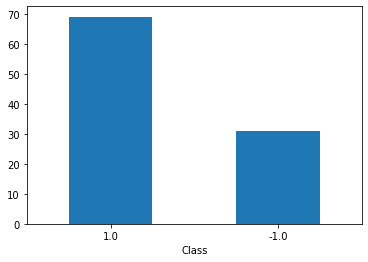

 1.0    69
-1.0    31
Name: 0, dtype: int64


In [57]:
train_df[0].value_counts().plot.bar(rot=360)
plt.xlabel('Class')
plt.show()
print(train_df[0].value_counts())

#  1: Normal
# -1: Infarction

In [58]:
X_train = train_df.drop(columns=0).values
y_train = train_df[0].values
X_test = test_df.drop(columns=0).values
y_test = test_df[0].values

# Class for y
encode_label = LabelEncoder()
encode_label.fit(y_train)
y_train = encode_label.transform(y_train)
y_test = encode_label.transform(y_test)

In [59]:
def plot_normal_ECG(normal_idx_list):
    fig, ax = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
    for i, idx in enumerate(normal_idx_list):
        ax[i].plot(range(len(X_train[normal_idx_list[i]])), X_train[normal_idx_list[i]])
        ax[i].set_title(f'Нормальная ЭКГ')
        ax[i].grid()
    plt.show()

In [60]:
def plot_abnormal_ECG(abnormal_idx_list):
    fig, ax = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
    for i, idx in enumerate(abnormal_idx_list):
        ax[i].plot(range(len(X_train[abnormal_idx_list[i]])), X_train[abnormal_idx_list[i]])
        ax[i].set_title(f'ЭКГ инфаркта миокарда')
        ax[i].grid()
    plt.show()

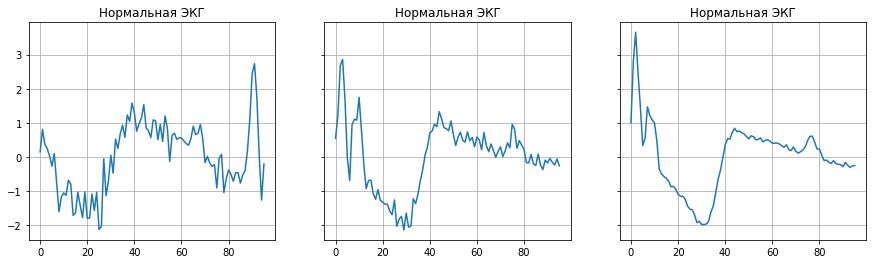

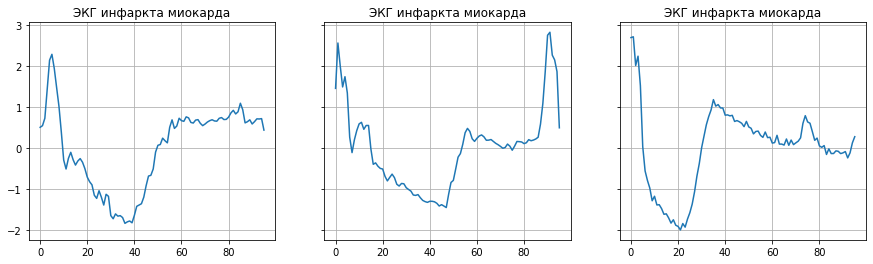

In [61]:
plot_normal_ECG([1, 71, 37])
plot_abnormal_ECG([0, 47, 96])

In [62]:
def plot_ECG(normal_idx, abnormal_idx):
    fig, ax = plt.subplots(1, 2, figsize=(9, 4), sharey=True)
    ax[0].plot(range(len(X_train[normal_idx])), X_train[normal_idx])
    ax[0].set_title(f'Нормальная ЭКГ')
    ax[0].grid()
    ax[1].plot(range(len(X_train[abnormal_idx])), X_train[abnormal_idx])
    ax[1].set_title(f'ЭКГ инфаркта миокарда')
    ax[1].grid()
    plt.show()

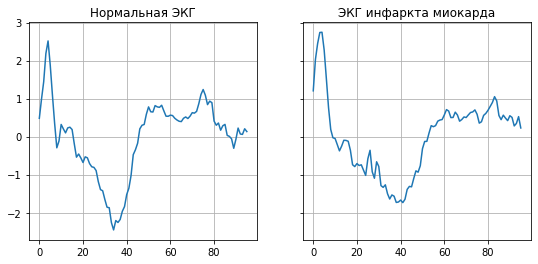

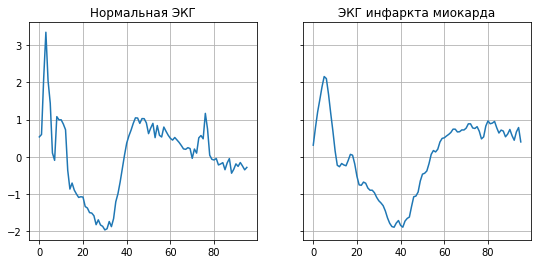

In [63]:
normal_idx = np.where(y_train==1)[0][5]
abnormal_idx = np.where(y_train==0)[0][3]
plot_ECG(normal_idx, abnormal_idx)
normal_idx = np.where(y_train==1)[0][32]
abnormal_idx = np.where(y_train==0)[0][11]
plot_ECG(normal_idx, abnormal_idx)

Как мы видим на приведенных выше рисунках, человеку не очень легко различать типы сигналов ЭКГ.

In [64]:
# изменить форму X, чтобы он мог проходить через слой LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


## 2.1 Двунаправленный автоэнкодер LSTM

In [65]:
class LSTMEncoderDecoder(keras.models.Model):
    def __init__(self):
        super(LSTMEncoderDecoder, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.2, input_shape=[96,1]), name='Bi-LSTM1'),
            layers.Bidirectional(layers.LSTM(32, dropout=0.2), name='Bi-LSTM2')])
        
        self.decoder = tf.keras.Sequential([
            layers.RepeatVector(96, input_shape=[64]),
            layers.Bidirectional(layers.LSTM(32, return_sequences=True, dropout=0.2), name='Bi-LSTM3'),
            layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.2), name='Bi-LSTM4'),
            layers.TimeDistributed(layers.Dense(1))])
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [66]:
def plot_history(history, loss=True, validation=False):
    if loss:
        plt.plot(history.history["loss"], label="Training Loss")
        if validation:
            plt.plot(history.history["val_loss"], label="Validation Loss") 
        plt.legend()
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.show()
    else:
        plt.plot(history.history["accuracy"], label="Training Accuracy")
        if validation:
            plt.plot(history.history["val_accuracy"], label="Validation Accuracy") 
        plt.legend()
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.show()

In [67]:
autoencoder = LSTMEncoderDecoder()
autoencoder.compile(optimizer='adam', loss='mse')

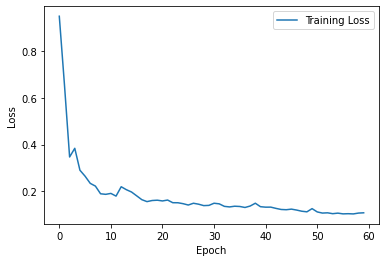

In [68]:
history = autoencoder.fit(X_train, X_train, epochs=60, batch_size=8, verbose=0) # validation_split=0.15, shuffle=True
plot_history(history, loss=True, validation=False)

In [69]:
autoencoder.encoder.summary()
autoencoder.decoder.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Bi-LSTM1 (Bidirectional)    (None, 96, 128)           33792     
                                                                 
 Bi-LSTM2 (Bidirectional)    (None, 64)                41216     
                                                                 
Total params: 75,008
Trainable params: 75,008
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 repeat_vector_6 (RepeatVect  (None, 96, 64)           0         
 or)                                                             
                                                                 
 Bi-LSTM3 (Bidirectional)    (None, 96, 64)            24832     
                          

## 2.2 Модель прогнозируемого глубокого обучения

Теперь мы используем кодировочную часть нашего автокодировщика для контролируемой модели классификации.

In [70]:
x = autoencoder.encoder.output
x = layers.Dense(1, activation='sigmoid')(x)
predictive_model = keras.Model(autoencoder.encoder.input, x)

In [71]:
predictive_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Bi-LSTM1_input (InputLayer)  [(None, 96, 1)]          0         
                                                                 
 Bi-LSTM1 (Bidirectional)    (None, 96, 128)           33792     
                                                                 
 Bi-LSTM2 (Bidirectional)    (None, 64)                41216     
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 75,073
Trainable params: 75,073
Non-trainable params: 0
_________________________________________________________________


In [72]:
x = autoencoder.encoder.output
x = layers.Dense(1, activation='sigmoid')(x)
predictive_model = keras.Model(autoencoder.encoder.input, x)

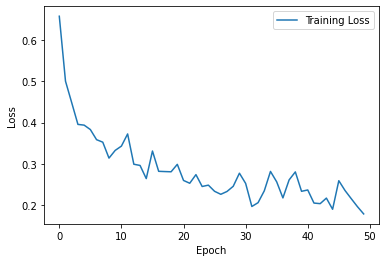

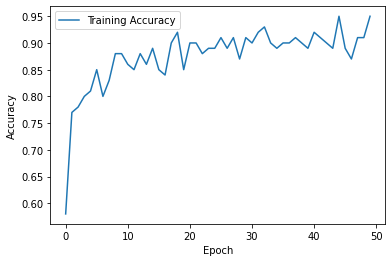

In [73]:
predictive_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy"])
model_history = predictive_model.fit(X_train, y_train, epochs=50, batch_size=8, verbose=0)
plot_history(model_history, loss=True, validation=False)
plot_history(model_history, loss=False, validation=False)

In [74]:
predictive_model.save('semi_supervised_lstm.h5')

## 2.2.1. Оценка

In [75]:
pred_test = predictive_model.predict(X_test)
pred_test = np.where(pred_test > 0.5, 1,0).reshape(-1,)
print(f'Test Accuracy: {accuracy_score(y_test, pred_test)*100}%')
print(f'Test F1 Score: {f1_score(y_test, pred_test)*100:.1f}%')

Test Accuracy: 81.0%
Test F1 Score: 85.9%


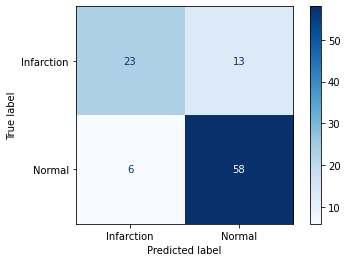

In [76]:
cm = confusion_matrix(y_test, pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Infarction", "Normal"])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [77]:
print(classification_report(y_test, pred_test, target_names=["Infarction", "Normal"]))

              precision    recall  f1-score   support

  Infarction       0.79      0.64      0.71        36
      Normal       0.82      0.91      0.86        64

    accuracy                           0.81       100
   macro avg       0.81      0.77      0.78       100
weighted avg       0.81      0.81      0.80       100



Интересно, что мы получаем более высокую точность, чем лучшая точность для этого набора данных (показанного на веб-сайте: http://www.timeseriesclassification.com/description.php?Dataset=ECG200). Моя полууправляемая модель набрала 81% результатов тестирования.

Помимо точности модели, если посмотреть на оценку отзыва для инфаркта, она составляет всего около 64%, что означает, что модель все еще может иметь высокие шансы диагностировать инфарктное сердцебиение как обычно, что является серьезной проблемой, которую следует избегать на практике.
В любом случае, наша цель  - продемонстрировать использование полууправляемого обучения для повышения производительности прогнозных моделей, особенно при работе с небольшим набором данных.

## Использование контролируемого LSTM

Теперь рассмотрим только производительность контролируемой модели, не изучая особенности автокодировщика.

In [78]:
def Supervised_model():
    model = keras.Sequential(name='Supervised_LSTM')
    model.add(keras.layers.InputLayer(input_shape=(96, 1), name='Input'))
    model.add(layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.2), name='Bi-LSTM1'))
    model.add(layers.Bidirectional(layers.LSTM(32, dropout=0.2), name='Bi-LSTM2'))
    model.add(layers.Dense(1, activation='sigmoid', name='Output'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


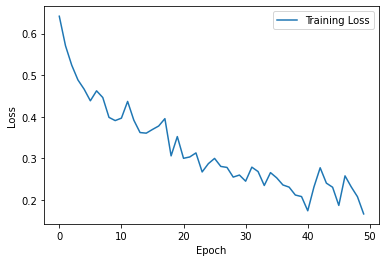

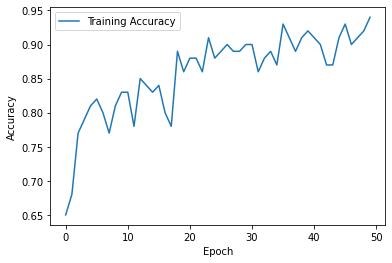

In [79]:
model = Supervised_model()
history = model.fit(X_train, y_train, batch_size=8, epochs=50, verbose=0)
plot_history(history, loss=True, validation=False)
plot_history(history, loss=False, validation=False)

In [80]:
pred_test = model.predict(X_test)
pred_test = np.where(pred_test > 0.5, 1,0).reshape(-1,)
print(f'Test Accuracy: {accuracy_score(y_test, pred_test)*100}%')
print(f'Test F1 Score: {f1_score(y_test, pred_test)*100:.1f}%')

Test Accuracy: 83.0%
Test F1 Score: 87.6%


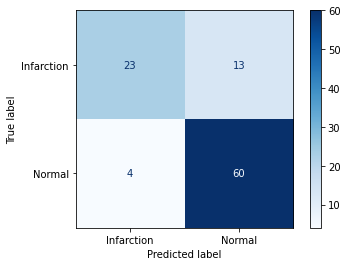

In [81]:
cm = confusion_matrix(y_test, pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Infarction", "Normal"])
disp.plot(cmap=plt.cm.Blues)
plt.show()

## 2.3 Модель прогнозного машинного обучения

Поскольку у нас довольно много обучающих выборок, мы также попробуем традиционную модель машинного обучения, такую как случайный лес. Тем не менее, мы будем использовать скрытое измерение в качестве входных данных для классификатора.

In [82]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, StratifiedKFold

In [83]:
model = load_model('semi_supervised_lstm.h5')
latent_model = tf.keras.models.Model(inputs=model.input, outputs=model.layers[-2].output)

In [84]:
encoded_train = latent_model.predict(X_train)
encoded_test = latent_model.predict(X_test)

Используем 5-кратную вложенную перекрестную проверку для поиска оптимальных параметров и оценки модели.

In [85]:
model = RandomForestClassifier(random_state=0)

parameters = {'n_estimators':[10, 50, 100],
             'max_features':['sqrt']}

# configure the cross-validation procedure
cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

clf = GridSearchCV(model, parameters, n_jobs=-1, cv=cv_inner, refit=True)
clf.fit(encoded_train,y_train)
print('Selected parameters')
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, clf.best_params_[param_name]))   

# execute the nested cross-validation
acc_scores = cross_val_score(clf, encoded_train,y_train, scoring='accuracy', cv=cv_outer, n_jobs=-1)
# report performance
print('Nested 5-fold Cross-validation')
print('Accuracy: %.3f (%.3f)' % (np.mean(acc_scores), np.std(acc_scores)))

Selected parameters
max_features: 'sqrt'
n_estimators: 10
Nested 5-fold Cross-validation
Accuracy: 0.860 (0.073)


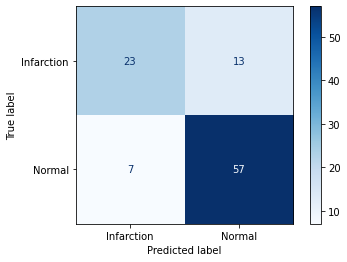

In [86]:
y_pred = clf.predict(encoded_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Infarction", "Normal"])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [87]:
print(classification_report(y_test, y_pred, target_names=["Infarction", "Normal"]))

              precision    recall  f1-score   support

  Infarction       0.77      0.64      0.70        36
      Normal       0.81      0.89      0.85        64

    accuracy                           0.80       100
   macro avg       0.79      0.76      0.77       100
weighted avg       0.80      0.80      0.80       100



In [88]:
print(f'Test Accuracy: {accuracy_score(y_test,y_pred)*100}%')
print(f'Test F1 Score: {f1_score(y_test, y_pred)*100:.1f}%')

Test Accuracy: 80.0%
Test F1 Score: 85.1%


In [89]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])

model = RandomForestClassifier(random_state=0)

parameters = {'n_estimators':[10, 50, 100],
             'max_features':['sqrt']}

# configure the cross-validation procedure
cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

clf = GridSearchCV(model, parameters, n_jobs=-1, cv=cv_inner, refit=True)
clf.fit(X_train,y_train)
print('Selected parameters')
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, clf.best_params_[param_name]))   

# execute the nested cross-validation
acc_scores = cross_val_score(clf, X_train,y_train, scoring='accuracy', cv=cv_outer, n_jobs=-1)
# report performance
print('Nested 5-fold Cross-validation')
print('Accuracy: %.3f (%.3f)' % (np.mean(acc_scores), np.std(acc_scores)))

Selected parameters
max_features: 'sqrt'
n_estimators: 100
Nested 5-fold Cross-validation
Accuracy: 0.820 (0.112)


In [90]:
y_pred = clf.predict(X_test)
print(f'Test Accuracy: {accuracy_score(y_test,y_pred)*100}%')
print(f'Test F1 Score: {f1_score(y_test, y_pred)*100:.1f}%')

Test Accuracy: 83.0%
Test F1 Score: 87.0%
